In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


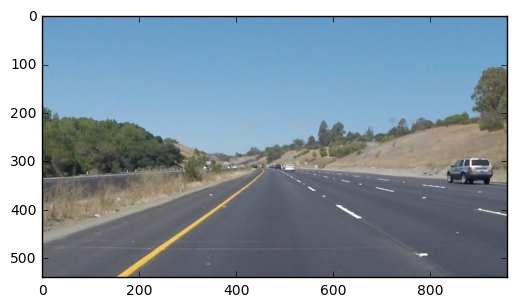

In [146]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg').astype('uint8')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    print('lines quantity: ', str(len(lines)))
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [223]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    lines = lines.reshape(lines.shape[0], lines.shape[2])
    slopes = (lines[:, 3] - lines[:, 1]) / (lines[:, 2] - lines[:, 0])
    lines = lines[~np.isnan(slopes) & ~np.isinf(slopes)]
    slope = slopes[~np.isnan(slopes) & ~np.isinf(slopes)]

    y_max = img.shape[0]
    y_min = lines.reshape([lines.shape[0] * 2, lines.shape[1] // 2])[:, 1].min()
    right_threshold = 0
    right_slope = slope[slope < right_threshold]
    right_lines = lines[slope < right_threshold]

    left_threshold = 0
    left_slope = slope[slope > left_threshold]
    left_lines = lines[slope > left_threshold]
    avg_right_slope = right_slope.mean()
    avg_right_x, avg_right_y = np.mean(right_lines.reshape(right_lines.shape[0] * 2, right_lines.shape[1] // 2), axis=0)
    right_intercept = avg_right_y - (avg_right_slope * avg_right_x)
    print('y_min is: ', y_min, ' right_intercept is: ', right_intercept, ' average_right_slope is: ', avg_right_slope)
    x_right_lowest = float(y_min - right_intercept) / avg_right_slope
    x_right_max = float(y_max - right_intercept) / avg_right_slope
    cv2.line(img, (int(x_right_max), int(y_max)), (int(x_right_lowest), int(y_min)), color, thickness)

    avg_left_slope = left_slope.mean()
    avg_left_x, avg_left_y = np.mean(left_lines.reshape(left_lines.shape[0] * 2, left_lines.shape[1] // 2), axis=0)
    left_intercept = avg_left_y - (avg_left_slope * avg_left_x)
    print('y_min is: ', y_min, ' left_intercept is: ', left_intercept, ' average_left_slope is: ', avg_left_slope)
    x_left_lowest = float(y_min - left_intercept) / avg_left_slope
    x_left_max = float(y_max - left_intercept) / avg_left_slope
    cv2.line(img, (int(x_left_max), int(y_max)), (int(x_left_lowest), int(y_min)), color, thickness)

In [224]:
import os
img_list = os.listdir("test_images/")

In [225]:
def detect_lane_line(image):
    gray_img = grayscale(image)
    blur_gray = gaussian_blur(gray_img, kernel_size=5)
    edges = canny(blur_gray, low_threshold=50, high_threshold=150)
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(480, 310), (490, 315), (900,imshape[0])]])
    marked_edges = region_of_interest(edges, vertices)
    line_img = hough_lines(marked_edges, rho=2, theta=(np.pi/180), threshold=5, min_line_len=5, max_line_gap=20)
    final_image = weighted_img(line_img, image)
    return final_image

In [228]:
def detect_lane_line(image):
    gray_img = grayscale(image)
    blur_gray = gaussian_blur(gray_img, kernel_size=5)
    edges = canny(blur_gray, low_threshold=50, high_threshold=150)
    imshape = image.shape
    # vertices = np.array([[(100,imshape[0]),(480, 310), (490, 315), (900,imshape[0])]])
    vertices = np.array([[(0,imshape[0]),(450, 310), (490, 315), (imshape[1],imshape[0])]])
    marked_edges = region_of_interest(edges, vertices)
    line_img = hough_lines(marked_edges, rho=2, theta=(np.pi/180), threshold=15, min_line_len=40, max_line_gap=20)
    final_image = weighted_img(line_img, image)
    return final_image

In [229]:
def read_image(image_path):
    image = mpimg.imread(image_path).astype('uint8')
    print('This image is:', type(image), 'with dimesions:', image.shape)
    return image


def plot_and_save(image, image_name, processed_img_dir):
    plt.figure()
    plt.imshow(image)
    img_path = processed_img_dir + image_name
    clean_target_dir(processed_img_dir, image_name)
    plt.savefig(img_path)
    
    
def clean_target_dir(dir, img_name):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    img_path = dir + img_name
    if os.path.isfile(img_path):
        os.remove(img_path)
    

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
y_min is:  313  right_intercept is:  661.402948983  average_right_slope is:  -0.714906736573
y_min is:  313  left_intercept is:  41.3253518933  average_left_slope is:  0.564578998331
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
y_min is:  312  right_intercept is:  664.107352122  average_right_slope is:  -0.741878102124
y_min is:  312  left_intercept is:  67.6198843208  average_left_slope is:  0.526680393738
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
y_min is:  312  right_intercept is:  602.867520964  average_right_slope is:  -0.599515897796
y_min is:  312  left_intercept is:  -1.760859585  average_left_slope is:  0.64341830564
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
y_min is:  312  right_intercept is:  630.209708257  average_right_slope is:  -0.654452555433
y_min is:  312  left_intercept is:  32.8267182402  average_left_slope is:  0.5872836

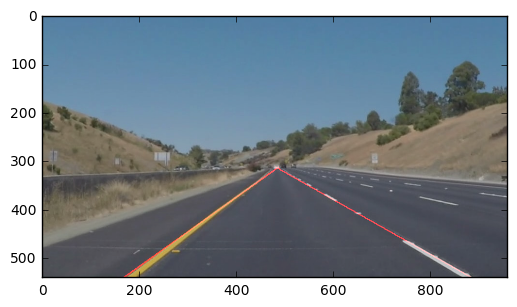

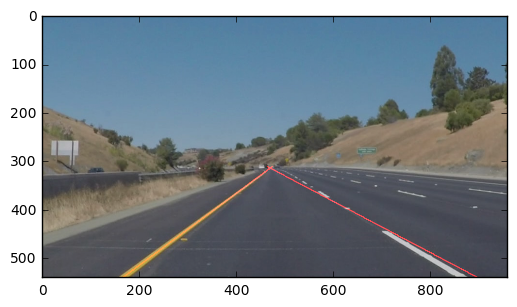

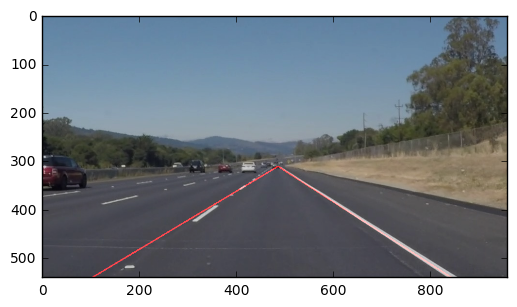

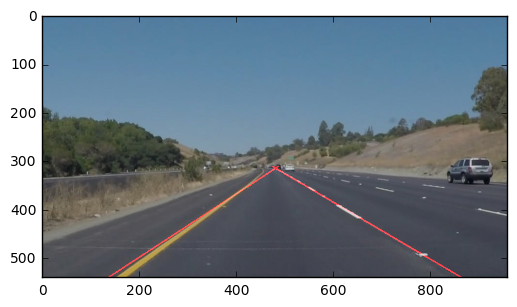

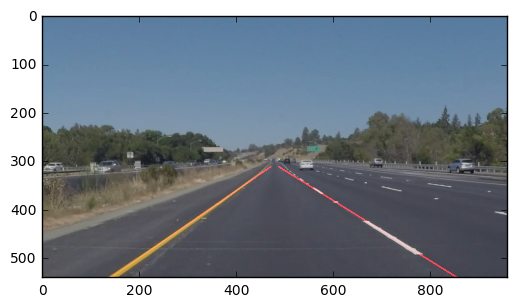

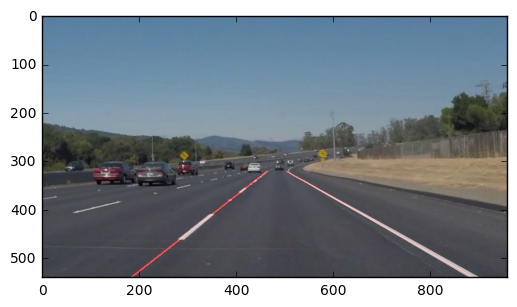

In [230]:
image_dir = 'test_images/'
processed_img_dir = image_dir + 'processed/'
for image_name in img_list:
    image_path = image_dir + image_name
    if os.path.isdir(image_path):
        continue
    image = read_image(image_path)
    processed_image = detect_lane_line(image)
    plot_and_save(processed_image, image_name, processed_img_dir)

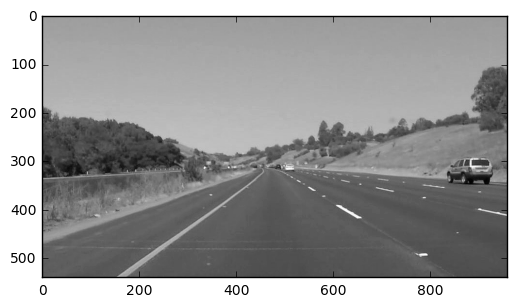

In [147]:
gray_img = grayscale(image)
# plt.imshow(gray_img)
plt.imshow(gray_img, cmap='gray')

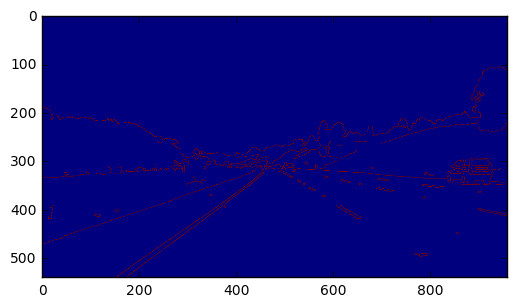

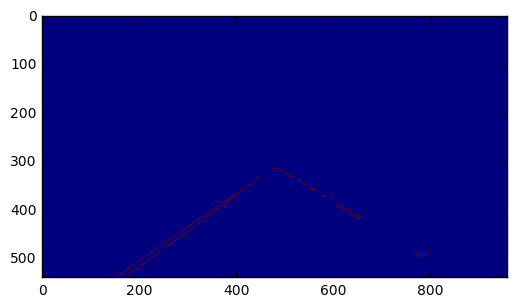

In [231]:
blur_gray = gaussian_blur(gray_img, kernel_size=5)

edges = canny(blur_gray, low_threshold=50, high_threshold=150)

plt.imshow(edges)

imshape = image.shape
vertices = np.array([[(150,imshape[0]),(480, 310), (485, 315), (900,imshape[0])]])
marked_edges = region_of_interest(edges, vertices)
plt.figure()
plt.imshow(marked_edges)

the distance is:  [ 311.40006423   60.6052803    91.02197537  151.47607072  198.25236442]
(16, 4)
(32, 2)
y_min is:  310
[[280 451]
 [487 316]
 [657 418]
 [412 357]
 [308 440]]
this is the right_lines_mean [ 428.8  396.4]
this is the left_lines_mean [ 293.27272727  446.36363636]


/home/cj/anaconda3/envs/sdcn/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 16
/home/cj/anaconda3/envs/sdcn/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 32 but corresponding boolean dimension is 16


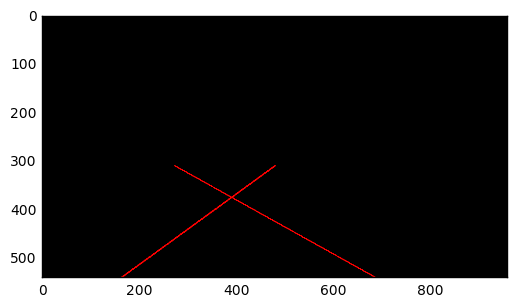

In [157]:
line_img = hough_lines(marked_edges, rho=2, theta=(np.pi/180), threshold=10, min_line_len=30, max_line_gap=30)
plt.imshow(line_img)

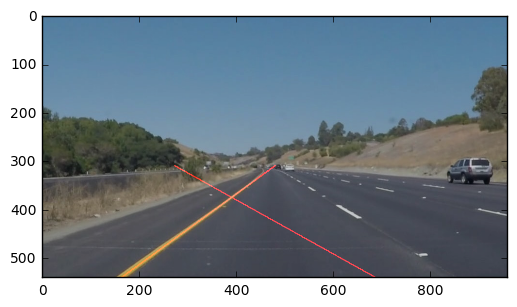

In [158]:
final_image = weighted_img(line_img, image)
plt.imshow(final_image)